In [6]:
import jax
import jax.numpy as jnp
import numpy as np
import chex
from flyjax.agent.model import base_agent
from flyjax.simulation.simulate import simulate_experiment_jit, simulate_dataset_jit, simulate_dataset_jit_different_params
from flyjax.simulation.parse import parse_reward_matrix
from flyjax.fitting.cv import k_fold_cross_validation_train, \
    k_fold_cross_validation_train_joint, \
    k_fold_cross_validation_train_hierarchical, \
    parallel_k_fold_cross_validation_train, \
    parallel_k_fold_cross_validation_train_joint, \
    parallel_k_fold_cross_validation_train_hierarchical
from flyjax.utils.plotting import plot_experiment_data
from typing import Tuple, Dict, Any, List, Callable, Optional

In [7]:
# 0. Set up random number generator
rng_key = jax.random.PRNGKey(0)
    
# 1. Define "true" parameters
true_params = jnp.array([2.0, -1.0, 1.0, 0.1])
print("True params:", true_params)

True params: [ 2.  -1.   1.   0.1]


# Generate a dataset with the simulation code and fit a model to it. The model should be able to predict the parameters of the simulation code.

In [8]:
# --- Set true parameters for simulation ---
# params = [alpha_learn_logit, alpha_forget_logit, kappa_reward, kappa_omission]
true_params = jnp.array([2.0, -1.0, 1.0, 0.1])
print("True parameters:", true_params)

# --- Simulate a dataset ---
# Define the reward probabilities for each experiment.
n_replicates = 8
reward_matrices = [
    parse_reward_matrix("[0.0,0.0]x30;[0.33,0.17]x40;[0.33,0.67]x40;[0.17,0.33]x40;[0.89,0.11]x40;[0.33,0.17]x40"),
    parse_reward_matrix("[0.0,0.0]x30;[0.33,0.17]x40;[0.33,0.67]x40;[0.89,0.11]x40;[0.67,0.33]x40;[0.17,0.33]x40"),
    parse_reward_matrix("[0.0,0.0]x30;[0.33,0.17]x40;[0.11,0.89]x40;[0.17,0.33]x40;[0.67,0.33]x40;[0.33,0.17]x40"),
    parse_reward_matrix("[0.0,0.0]x30;[0.33,0.17]x40;[0.11,0.89]x40;[0.67,0.33]x40;[0.89,0.11]x40;[0.17,0.33]x40"),
    parse_reward_matrix("[0.0,0.0]x30;[0.67,0.33]x40;[0.17,0.33]x40;[0.33,0.67]x40;[0.89,0.11]x40;[0.67,0.33]x40"),
    parse_reward_matrix("[0.0,0.0]x30;[0.67,0.33]x40;[0.17,0.33]x40;[0.89,0.11]x40;[0.33,0.17]x40;[0.33,0.67]x40"),
    parse_reward_matrix("[0.0,0.0]x30;[0.67,0.33]x40;[0.11,0.89]x40;[0.33,0.17]x40;[0.89,0.11]x40;[0.33,0.67]x40"),
    parse_reward_matrix("[0.0,0.0]x30;[0.67,0.33]x40;[0.11,0.89]x40;[0.33,0.67]x40;[0.89,0.11]x40;[0.67,0.33]x40"),
    parse_reward_matrix("[0.0,0.0]x30;[0.89,0.11]x40;[0.17,0.33]x40;[0.11,0.89]x40;[0.67,0.33]x40;[0.89,0.11]x40"),
    parse_reward_matrix("[0.0,0.0]x30;[0.89,0.11]x40;[0.17,0.33]x40;[0.67,0.33]x40;[0.33,0.17]x40;[0.11,0.89]x40"),
    parse_reward_matrix("[0.0,0.0]x30;[0.89,0.11]x40;[0.33,0.67]x40;[0.33,0.17]x40;[0.67,0.33]x40;[0.11,0.89]x40"),
    parse_reward_matrix("[0.0,0.0]x30;[0.89,0.11]x40;[0.33,0.67]x40;[0.11,0.89]x40;[0.33,0.17]x40;[0.89,0.11]x40")
]*n_replicates

rng_key = jax.random.PRNGKey(0)
rng_key, subkey = jax.random.split(rng_key)
choices, rewards = simulate_dataset_jit(true_params, jnp.stack(reward_matrices), base_agent, subkey, baiting=True)
n_experiments = len(reward_matrices)
# convert to experiment data format
experiments = [(choices[i], rewards[i]) for i in range(n_experiments)]

True parameters: [ 2.  -1.   1.   0.1]


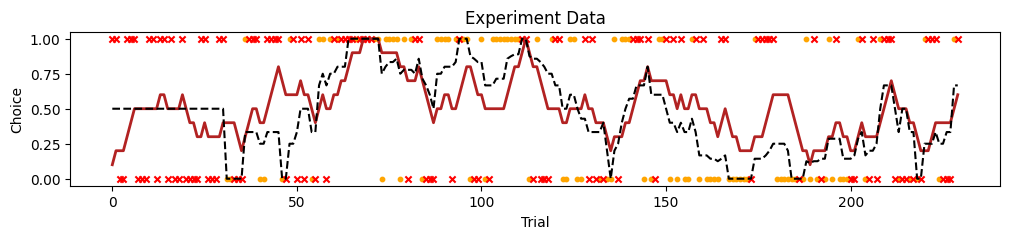

In [9]:
# Plot the first experiment.
plot_experiment_data(experiments[0])

In [ ]:
# create the sampler for the initial parameters
def init_param_sampler():
    return jnp.array(np.random.randn(4))

# train and evaluate the model
total_pred_ll, per_experiment_ll, params = k_fold_cross_validation_train(
    experiments=experiments,
    k=5,
    init_param_sampler= init_param_sampler,
    agent=base_agent,
    learning_rate=5e-2,
    num_steps=10000,
    n_restarts=10,
    min_num_converged=3,
    early_stopping={
        "min_delta": 1e-4,
    }
)


In [ ]:
param_vals = np.array(list(params.values())).mean(axis=0)
print("Estimated parameters:", param_vals)
print("True parameters:", true_params)

In [10]:
# Lets generate some experiments with some modified parameters to test the multi group training

# --- Set perturbed parameters for simulation ---
# params = [alpha_learn_logit, alpha_forget_logit, kappa_reward, kappa_omission]
perturbed_params = jnp.array([2.5, 0.0, 0.8, 0.0])
print("Perturbed parameters:", perturbed_params)

# --- Simulate a dataset with perturbed parameters ---
rng_key, subkey = jax.random.split(rng_key)
perturbed_choices, perturbed_rewards = simulate_dataset_jit(perturbed_params, jnp.stack(reward_matrices), base_agent, subkey, baiting=True)
n_perturbed_experiments = len(reward_matrices)
# convert to experiment data format
perturbed_experiments = [(perturbed_choices[i], perturbed_rewards[i]) for i in range(n_perturbed_experiments)]

Perturbed parameters: [2.5 0.  0.8 0. ]


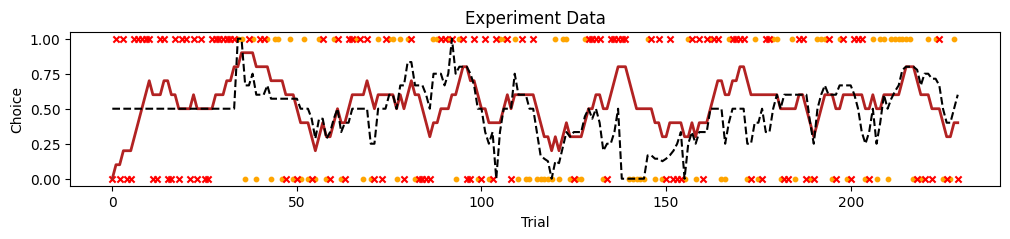

In [11]:
# Plot the first experiment.
plot_experiment_data(perturbed_experiments[5])

In [ ]:
# Define samplers for initial parameters.
def sample_init_theta() -> chex.Array:
    # For instance, sample control parameters from a standard normal distribution.
    return jnp.array(np.random.randn(4))

def sample_init_delta() -> chex.Array:
    # Sample delta from a small-variance normal distribution.
    return jnp.array(0.1 * np.random.randn(4))

# train and evaluate the model
total_pred_ll, per_experiment_ll, params = k_fold_cross_validation_train_joint(
    experiments_control=experiments,
    experiments_treatment=perturbed_experiments,
    init_theta_sampler=sample_init_theta,
    init_delta_sampler=sample_init_delta,
    k=5,
    agent=base_agent,
    learning_rate=5e-2,
    num_steps=10000,
    n_restarts=10,
    min_num_converged=3,
    early_stopping={
        "min_delta": 1e-4,
    }
)

In [ ]:
theta = np.array(list(params.values())).mean(axis=0)[0]
delta = np.array(list(params.values())).mean(axis=0)[1]

In [ ]:
print("True Control Parameters:", true_params)
print("Control Parameters:", theta)
print("True Experimental Parameters:", perturbed_params)
print("Experimental Parameters:", theta + delta)


In [ ]:
# Evaluate the joint model on the two groups.
nll_control, nll_exp, joint_nll = evaluate_joint_model(
    best_theta, best_delta, base_agent, experiments, perturbed_experiments, delta_penalty_sigma=1.0
)
print(f"\nEvaluation:")
print(f"  Control NLL: {nll_control:.4f}")
print(f"  Experimental NLL: {nll_exp:.4f}")
print(f"  Joint NLL: {joint_nll:.4f}")
print(f"  Delta penalty: {joint_nll - nll_control - nll_exp:.4f}")

In [12]:
# --- Multi subject training ---

# build a dataset with multiple subjects assuming each subject has the different parameters sampled from a normal distribution
n_subjects = len(reward_matrices)
subject_params = []
for _ in range(n_subjects):
    rng_key, subkey = jax.random.split(rng_key)
    subject_params.append(true_params + 0.2*jax.random.normal(rng_key, shape=true_params.shape))

# Simulate the dataset for each subject.
rng_key, subkey = jax.random.split(rng_key)
choices, rewards = simulate_dataset_jit_different_params(jnp.stack(subject_params), jnp.stack(reward_matrices), base_agent, rng_key, baiting=True)
# Assuming 'choices' and 'rewards' are produced by simulate_dataset_jit_different_params
n_experiments = choices.shape[0]
subject_experiments = [[(np.array(choices[i]), np.array(rewards[i]))] for i in range(n_experiments)] # this is done because we assume each subject has only one experiment


In [ ]:
print("Number of subjects:", n_subjects)
print("True parameters for the subjects:", subject_params)

# Define samplers for initial parameters.
def sample_init_theta_pop() -> chex.Array:
    # For instance, sample population-level parameters from a standard normal distribution.
    return jnp.array(np.random.randn(4))

def make_sample_init_theta_subjects(n: int) -> Callable[[], chex.Array]:
    def sample():
        return jnp.array(np.random.randn(n, 4))
    return sample

# train and evaluate the model
total_pred_ll, per_experiment_ll, params = k_fold_cross_validation_train_hierarchical(
    experiments_by_subject=subject_experiments,
    init_theta_pop_sampler=sample_init_theta_pop,
    make_sample_init_theta_subjects=make_sample_init_theta_subjects,
    k=5,
    agent=base_agent,
    learning_rate=5e-2,
    num_steps=10000,
    n_restarts=10,
    min_num_converged=3,
    early_stopping={
        "min_delta": 1e-4,
    }
)

Number of subjects: 96
True parameters for the subjects: [Array([ 1.7074176 , -1.0703456 ,  0.967721  , -0.05662847], dtype=float32), Array([ 1.6867114 , -1.1560814 ,  0.7477006 ,  0.30806813], dtype=float32), Array([ 1.8532976 , -0.73311317,  1.3035392 , -0.07623582], dtype=float32), Array([ 2.040987  , -0.80223036,  0.9972477 ,  0.24306133], dtype=float32), Array([ 1.9684147 , -1.0992843 ,  0.9900699 ,  0.32679555], dtype=float32), Array([ 1.9831579 , -0.7629758 ,  1.1385388 , -0.10341506], dtype=float32), Array([ 1.936808  , -0.83503234,  1.4716271 ,  0.24968287], dtype=float32), Array([ 1.9686192 , -1.0337689 ,  1.232622  , -0.00510482], dtype=float32), Array([ 2.2289677 , -1.3602388 ,  1.1522466 ,  0.18426695], dtype=float32), Array([ 1.9596618 , -0.7156086 ,  1.1662055 ,  0.22523156], dtype=float32), Array([ 1.8680817 , -1.3863366 ,  1.3960499 ,  0.17726168], dtype=float32), Array([ 1.9549723 , -1.064041  ,  1.0234969 , -0.07199951], dtype=float32), Array([ 2.4089468, -0.6001693,

Hierarchical Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Step    0, Hierarchical NLL: 13300.4375
Step  100, Hierarchical NLL: 11356.6924
Step  200, Hierarchical NLL: 11339.5635
Convergence reached at step 300 with relative change 0.0001.
Restart 1 final Hierarchical NLL: 11338.8389

--- Hierarchical Restart 2/10 ---


Hierarchical Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Step    0, Hierarchical NLL: 13169.2949
Step  100, Hierarchical NLL: 11350.2920
Step  200, Hierarchical NLL: 11339.5195
Convergence reached at step 300 with relative change 0.0001.
Restart 2 final Hierarchical NLL: 11338.8291

--- Hierarchical Restart 3/10 ---


Hierarchical Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Step    0, Hierarchical NLL: 12946.8242
Step  100, Hierarchical NLL: 11346.3857
Step  200, Hierarchical NLL: 11338.9717
Convergence reached at step 300 with relative change 0.0000.
Restart 3 final Hierarchical NLL: 11338.7881
Stopping early because 3 runs have converged to the current best loss.

Best Hierarchical NLL: 11338.7881
Fold 1 predictive log-likelihood: -3023.6053

=== Hierarchical Fold 2/5 ===

--- Hierarchical Restart 1/10 ---


Hierarchical Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Step    0, Hierarchical NLL: 13921.3525
Step  100, Hierarchical NLL: 11495.1279
Step  200, Hierarchical NLL: 11466.7627
Step  300, Hierarchical NLL: 11464.8604
Convergence reached at step 400 with relative change 0.0000.
Restart 1 final Hierarchical NLL: 11464.7344

--- Hierarchical Restart 2/10 ---


Hierarchical Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Step    0, Hierarchical NLL: 13453.4473
Step  100, Hierarchical NLL: 11479.8652
Step  200, Hierarchical NLL: 11465.0947
Convergence reached at step 300 with relative change 0.0000.
Restart 2 final Hierarchical NLL: 11464.7324

--- Hierarchical Restart 3/10 ---


Hierarchical Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Step    0, Hierarchical NLL: 13533.6602
Step  100, Hierarchical NLL: 11488.0928
Step  200, Hierarchical NLL: 11465.0869
Convergence reached at step 300 with relative change 0.0000.
Restart 3 final Hierarchical NLL: 11464.7305
Stopping early because 3 runs have converged to the current best loss.

Best Hierarchical NLL: 11464.7305
Fold 2 predictive log-likelihood: -2881.2408

=== Hierarchical Fold 3/5 ===

--- Hierarchical Restart 1/10 ---


Hierarchical Training:   0%|          | 0/10000 [00:00<?, ?it/s]